In [1]:
# for data
import json
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for processing
from collections import defaultdict  # for word frequency
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from time import time
from gensim.models.phrases import Phrases, Phraser
import spacy  # for preprocessing
import en_core_web_sm

# for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

# for explainer
from lime import lime_text

# for word embedding
import gensim
import gensim.downloader as gensim_api

# for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

# for bert language model
import transformers

import logging  # setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15714\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\15714\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\15714\anaconda3\envs\cds490\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
df = pd.read_csv('data_cleaned.csv',index_col=0)

In [3]:
nlp = en_core_web_sm.load()

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
#https://spacy.io/usage/linguistic-features
    #Text: The original word text.
    #Lemma: The base form of the word.
    #POS: The simple UPOS part-of-speech tag.
    #Tag: The detailed part-of-speech tag.
    #Dep: Syntactic dependency, i.e. the relation between tokens.
    #Shape: The word shape – capitalization, punctuation, digits.
    #is alpha: Is the token an alpha character?
    #is stop: Is the token part of a stop list, i.e. the most common words of the language?

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

    
# re - regex sub    
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['text'])

C:\Users\15714\anaconda3\envs\cds490\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
# spaCy.pipe() to speed-up cleaning
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.11 mins


In [5]:
# remove missing values/duplicates
df_clean = pd.DataFrame({'clean':txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(6592, 1)

In [6]:
df_clean

,clean
0,activation sars coronavirus reveal
1,vitamin d low risk severe covid
2,s point contact trace willfully refuse ask a...
3,thank u life decide break macbook air right town
4,covid alert new york woman beat coronavirus ce...
...,...
10673,rt oh god namjoon cup yoongi oh god pls namjoo...
10674,michigan s
10675,testing kit prepare disease not exi
10676,ve test country combine trump s poor math sk...


In [7]:
from gensim.models.phrases import Phrases, Phraser

In [8]:
# taking list of list of words for input
sent = [row.split() for row in df_clean['clean']] # .split words in list of words

In [9]:
phrases = Phrases(sent, min_count=30, progress_per=10000) # detect n-grams - contiguous sequence on n items from a given sample of a text or speech

INFO - 07:28:44: collecting all words and their counts
INFO - 07:28:44: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 07:28:44: collected 44192 word types from a corpus of 58918 words (unigram + bigrams) and 6592 sentences
INFO - 07:28:44: using 44192 counts as vocab in Phrases<0 vocab, min_count=30, threshold=10.0, max_vocab_size=40000000>


In [10]:
bigram = Phraser(phrases)

INFO - 07:28:44: source_vocab length 44192
INFO - 07:28:45: Phraser built with 68 phrasegrams


In [11]:
sentences = bigram[sent]

In [12]:
list(sentences)

[['activation', 'sars', 'coronavirus', 'reveal'],
 ['vitamin', 'd', 'low', 'risk', 'severe', 'covid'],
 ['s',
  'point',
  'contact_trace',
  'willfully',
  'refuse',
  'ask',
  'attend',
  'mass',
  'gathering',
  'people'],
 ['thank', 'u', 'life', 'decide', 'break', 'macbook', 'air', 'right', 'town'],
 ['covid',
  'alert',
  'new',
  'york',
  'woman',
  'beat',
  'coronavirus',
  'celebrate',
  'th',
  'birthday',
  "'",
  'remarkable',
  "'",
  'global',
  'pande'],
 ['wear',
  'damn',
  'mask',
  'child',
  'wear',
  'child',
  'coronavirus',
  'neurological',
  'instead',
  'o'],
 ['hydroxychloroquine',
  'remdesivir',
  'combo',
  'dangerous',
  'covid',
  'patient',
  'fda'],
 ['med', 'school', 'bring', 'student', 'flood', 'applicant'],
 ['jesus',
  'christ',
  'lmao',
  'mean',
  'wild',
  'animal',
  've',
  'near',
  'domesticated',
  'one'],
 ['fourth',
  'july',
  'meet',
  'current',
  'surge',
  'covid',
  'case',
  'houston',
  'place',
  'safe',
  'home'],
 ['effective

In [13]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

10142

In [14]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['covid',
 'coronavirus',
 's',
 'people',
 'new',
 'say',
 'health',
 'virus',
 'rt',
 'case']

In [15]:
# training the model
import multiprocessing
from gensim.models import Word2Vec

The parameters:
- min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
- window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
- size = int - Dimensionality of the feature vectors. - (50, 300)
- sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
- alpha = float - The initial learning rate - (0.01, 0.05)
- min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00
- negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
- workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [16]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=150, # what is this? - made an arbitrary value
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

WARNING - 07:28:45: consider setting layer size to a multiple of 4 for greater performance


In [17]:
t = time()
w2v_model.build_vocab(sentences, progress_per=10000)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 07:28:45: collecting all words and their counts
INFO - 07:28:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 07:28:45: collected 10142 word types from a corpus of 56433 raw words and 6592 sentences
INFO - 07:28:45: Loading a fresh vocabulary
INFO - 07:28:45: effective_min_count=20 retains 578 unique words (5% of original 10142, drops 9564)
INFO - 07:28:45: effective_min_count=20 leaves 32413 word corpus (57% of original 56433, drops 24020)
INFO - 07:28:45: deleting the raw counts dictionary of 10142 items
INFO - 07:28:45: sample=6e-05 downsamples 578 most-common words
INFO - 07:28:45: downsampling leaves estimated 6645 word corpus (20.5% of prior 32413)
INFO - 07:28:45: estimated required memory for 578 words and 150 dimensions: 982600 bytes
INFO - 07:28:45: resetting layer weights


Time to build vocab: 0.0 mins


In [18]:
w2v_model.init_sims(replace=True)

INFO - 07:28:45: precomputing L2-norms of word weight vectors


In [19]:
w2v_model.wv.most_similar(positive=["covid"])

[('get', 0.23174086213111877),
 ('flag', 0.2111731469631195),
 ('nih', 0.21072283387184143),
 ('immunity', 0.2098272144794464),
 ('far', 0.19033490121364594),
 ('activity', 0.1851631999015808),
 ('vitamin_c', 0.17847146093845367),
 ('public', 0.17530634999275208),
 ('financial', 0.17315536737442017),
 ('thank', 0.16983142495155334)]

In [20]:
w2v_model.wv.similarity("coronavirus", 'covid')

-0.060569007

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [22]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 150), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=20).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

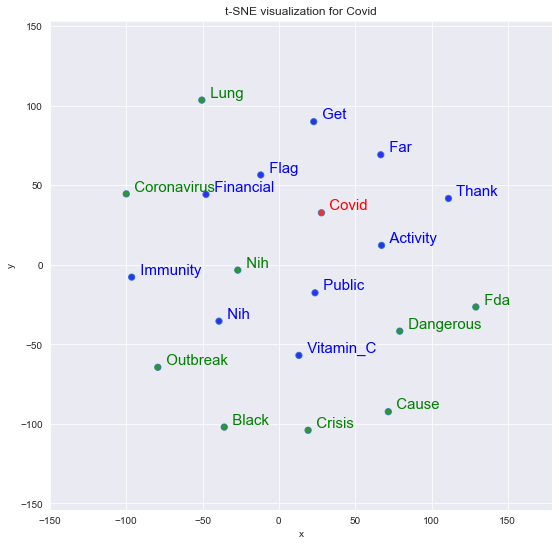

In [23]:
tsnescatterplot(w2v_model, 'covid', ['dangerous', 'black', 'coronavirus','nih','lung','crisis','cause','outbreak','fda'])

C:\Users\15714\anaconda3\envs\cds490\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
C:\Users\15714\anaconda3\envs\cds490\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
C:\Users\15714\anaconda3\envs\cds490\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


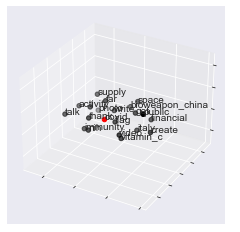

In [24]:
word = "covid"
fig = plt.figure()
## word embedding
tot_words = [word] + [tupla[0] for tupla in 
                 w2v_model.most_similar(word, topn=20)]
X = w2v_model[tot_words]
## pca to reduce dimensionality from 300 to 3
pca = manifold.TSNE(perplexity=40, n_components=3, init='pca')
X = pca.fit_transform(X)
## create dtf
dtf_ = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
dtf_["input"] = 0
dtf_["input"].iloc[0:1] = 1
## plot 3d
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtf_[dtf_["input"]==0]['x'], 
           dtf_[dtf_["input"]==0]['y'], 
           dtf_[dtf_["input"]==0]['z'], c="black")
ax.scatter(dtf_[dtf_["input"]==1]['x'], 
           dtf_[dtf_["input"]==1]['y'], 
           dtf_[dtf_["input"]==1]['z'], c="red")
ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
       yticklabels=[], zticklabels=[])
for label, row in dtf_[["x","y","z"]].iterrows():
    x, y, z = row
    ax.text(x, y, z, s=label)

# Neural Network

In [25]:
df_clean = pd.DataFrame({'text':df['text'],'text_clean':txt,'real':df['real']})
df_clean.dropna(subset=['text_clean'],inplace=True)

In [26]:
# split dataset
df_train, df_test = model_selection.train_test_split(df_clean, test_size=0.3)
# get target
y_train = df_train["real"].values
y_test = df_test["real"].values

In [27]:
# create list of lists of unigrams
corpus = df_train["text_clean"]
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) 
               for i in range(0, len(lst_words), 1)]
    lst_corpus.append(lst_grams)
# detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

INFO - 07:28:46: collecting all words and their counts
INFO - 07:28:46: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 07:28:46: collected 33917 word types from a corpus of 63504 words (unigram + bigrams) and 7210 sentences
INFO - 07:28:46: using 33917 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10, max_vocab_size=40000000>
INFO - 07:28:46: source_vocab length 33917
INFO - 07:28:47: Phraser built with 685 phrasegrams
INFO - 07:28:47: collecting all words and their counts
INFO - 07:28:47: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 07:28:47: collected 34278 word types from a corpus of 50487 words (unigram + bigrams) and 7210 sentences
INFO - 07:28:47: using 34278 counts as vocab in Phrases<0 vocab, min_count=5, threshold=10, max_vocab_size=40000000>
INFO - 07:28:47: source_vocab length 34278
INFO - 07:28:47: Phraser built with 855 phrasegrams


In [28]:
# tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index
# create sequence
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)
# padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [29]:
# feature engineering for test set
corpus = df_test["text_clean"]

# create list of n-grams
lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
# detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
# text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

# padding sequence
X_test = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=15,
             padding="post", truncating="post")

In [30]:
# create matrix of embedding
# start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))
for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

In [61]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation

model = Sequential()

# input layer
model.add(Dense(13,  activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))

# hidden layer
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.2))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [62]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',verbose=1,patience=3)

In [63]:
model.fit(x=X_train, 
          y=y_train, 
          epochs=1000,
          batch_size=256,
          validation_data=(X_test, y_test),
          callbacks=[early_stop]
          )

Epoch 1/1000
29/29 [==============================] - 0s 4ms/step - loss: 271.8747 - accuracy: 0.4890 - val_loss: 47.8318 - val_accuracy: 0.3890
Epoch 2/1000
29/29 [==============================] - 0s 1ms/step - loss: 104.6601 - accuracy: 0.4994 - val_loss: 30.9487 - val_accuracy: 0.4757
Epoch 3/1000
29/29 [==============================] - 0s 1ms/step - loss: 74.4807 - accuracy: 0.4974 - val_loss: 20.0231 - val_accuracy: 0.4858
Epoch 4/1000
29/29 [==============================] - 0s 1ms/step - loss: 61.2631 - accuracy: 0.4892 - val_loss: 13.5544 - val_accuracy: 0.6793
Epoch 5/1000
29/29 [==============================] - 0s 1ms/step - loss: 45.9677 - accuracy: 0.5024 - val_loss: 9.8675 - val_accuracy: 0.6806
Epoch 6/1000
29/29 [==============================] - 0s 1ms/step - loss: 38.3527 - accuracy: 0.4974 - val_loss: 8.1305 - val_accuracy: 0.6715
Epoch 7/1000
29/29 [==============================] - 0s 2ms/step - loss: 29.6389 - accuracy: 0.5137 - val_loss: 6.6314 - val_accuracy: 

<AxesSubplot:>

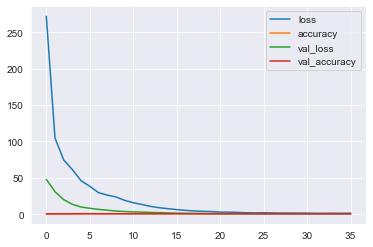

In [65]:
lstm_loss = pd.DataFrame(model.history.history)
lstm_loss.plot()

In [69]:
predicted_prob = model.predict(X_test)
predicted = [y_test[np.argmax(pred)] for pred in 
             predicted_prob]

In [72]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predicted))
print(confusion_matrix(y_test,predicted))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67      1547
           1       0.00      0.00      0.00      1543

    accuracy                           0.50      3090
   macro avg       0.25      0.50      0.33      3090
weighted avg       0.25      0.50      0.33      3090

[[1547    0]
 [1543    0]]


# Prototyping 2 Questions

## Question 1
I'm not exactly sure how to use the vectors I created via Word2Vec as inputs to my neural network. I've only been able to use Word2Vec to find model contextual similarities between words. Additionally, I tried to tokenize my text using TensorFlow's kprocessing library, but after using the tokens to train my model, the model only predicted values of 0. I need to go back and re-tune my model parameters to get better model performance.

## Question 3
I will find another dataset that has instances of legitimate news/disinformation already labelled, and validate my model on those instances.

## Question 4
My working hypothesis is that instances of disinformation contain certain keywords that legitimate news instances do not, and vice-versa.